# Quantum Tomography analysis

This is the analysis code to measure the polarisation of a vector meson using Quantum Tomography.

In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import pickle
import uproot
import numpy as np
import pandas as pd
# import xgboost as xgb
import sklearn

sys.path.insert(0, '../')
# import analysis_utils as au

# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## A few infos on the libraries

### uproot

uproot is a Python package that provides tools for reading/writing ROOT files using Python and Numpy (does not depend on ROOT) and is primarly intended to stream data into machine learning libraries in Python.

We use uproot for reading and converting ROOT Trees into ***pandas*** **DataFrame**.
For more details: https://github.com/scikit-hep/uproot.

Now we load our data using uproot: signal and background for the training of the models and the unknown data on which we would like to have the model predictions

In [2]:
# datatree = uproot.open('AnalysisResults.root')['Data']
# datatree = uproot.open('MC/AnalysisResultsCohJpsi_GridTest.root')['MyTask/fOutputTreeMC']
# datatree = uproot.open('MC/AnalysisResultsCohJpsiLocal.root')['MyTask/fOutputTreeMC']
# datatree = uproot.open('MC/AnalysisResultsCohJpsiLocal.root')['MyTask/fOutputTree']
# datatree = uproot.open('MC/AnalysisResultsCohJpsiLPLocal.root')['MyTask/fOutputTree']
datatree = uproot.open('MC/AnalysisResultsGammaGammaMediumLocal.root')['MyTask/fOutputTree']

In [3]:
datatree.keys()
# IncohMC_std_gener.keys()
# background_treeMine.keys()
# data_treeMine.keys()

[b'fTrkTrkPt',
 b'fTrkTrkY',
 b'fTrkTrkM',
 b'fTrkPx1',
 b'fTrkPy1',
 b'fTrkPz1',
 b'fTrkE1',
 b'fTrkPx2',
 b'fTrkPy2',
 b'fTrkPz2',
 b'fTrkE2']

In [4]:
data_df = datatree.pandas.df()

In [5]:
len(data_df.index)

1018

In [6]:
generatedevents = len(data_df.index)
generatedevents

1018

## Four-momentum logic

In [2]:
import skhep
from skhep import math


# Levi-Civita symbol
import sympy
from sympy import LeviCivita

Quantum tomography works by defining three coordinate axes in a Lorentz-invariant approach.

Using \\( k_+^\mu \\), \\(k_-^\mu \\) for the positive and the negative muon, respectively, we construct the vector meson 4-vector \\( Q^\mu \\) as:

\\[ Q^\mu = k_+^\mu + k_-^\mu \\]

If \\( p_A^\mu, p_B^\mu \\) are the two beams, the three axes \\( X^\mu, Y^\mu, Z^\mu \\) are defined as:

\\[ Z^\mu = p_A^\mu  Q{\cdot}p_B - p_B^\mu Q{\cdot}p_A \\]

\\[ Y^\mu = \epsilon^{\mu\nu\alpha\beta}p_{A \nu}p_{B \alpha}Q_\beta \\]

\\[ X^\mu = Q^\mu - p_A^\mu \frac{Q^2}{2Q{\cdot}p_A} - p_B^\mu \frac{Q^2}{2Q{\cdot}p_B} \\]





In [3]:
def CosThetaTrueCollinsSoper( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "X  = ", x )
#     print( "Y  = ", y )
#     print( "Z  = ", z )
#     print( "Xh = ", xhat )
#     print( "Yh = ", yhat )
#     print( "Zh = ", zhat )
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
    NormOfdiff = math.sqrt(-diff.dot(diff))
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [4]:
help(math.atan2)

Help on built-in function atan2 in module math:

atan2(y, x, /)
    Return the arc tangent (measured in radians) of y/x.
    
    Unlike atan(y/x), the signs of both x and y are considered.



In [5]:
def PhiTrueCollinsSoper( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
#     pA            = math.LorentzVector( 0, 0,-1, 1 )
#     pB            = math.LorentzVector( 0, 0, 1, 1 )
    pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
    pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
    NormOfdiff = math.sqrt(-diff.dot(diff))
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );
    PhiCS            = math.atan2( SinThetaSinPhiCS, SinThetaCosPhiCS );


    return PhiCS

    

#### Small test procedure
Here we are testing the few functions using our data.

In [11]:
data_df.iloc[4]

fTrkTrkPt     0.122269
fTrkTrkY     -3.157646
fTrkTrkM      3.797139
fTrkPx1       0.986519
fTrkPy1      -1.536682
fTrkPz1     -23.889266
fTrkE1       23.959190
fTrkPx2      -1.035686
fTrkPy2       1.648629
fTrkPz2     -20.698272
fTrkE2       20.789908
Name: 4, dtype: float64

In [12]:
CosThetaTest = CosThetaTrueCollinsSoper( 1.201056, 0.586901, 21.715403, 21.756766, -1.260339, -0.528812, -9.929302, 10.023487 )

In [13]:
CosThetaTest

0.995798810540499

In [14]:
LeviCivita(0,1,3,2)

-1

### Speed check

In [ ]:
data_df.loc[4:5]

In [ ]:
# singleline_df = data_df.loc[4:5]
# singleline_df

singleline = [ [1.348618, 0.352406, -48.828766, 48.848774, -1.334760, -0.386442, -19.233398, 19.283819, 0.036749, -3.783632, 3.096845],
               [0.610672, 1.115761,  -5.101897,  5.259121, -0.646307, -1.072639, -18.913221, 18.954929, 0.055941, -2.745375, 3.096976]]

singleline_df = pd.DataFrame(singleline, columns = ['fMCTrkPx1', 'fMCTrkPy1', 'fMCTrkPz1','fMCTrkE1','fMCTrkPx2', 'fMCTrkPy2', 'fMCTrkPz2','fMCTrkE2', 'fMCTrkTrkPt', 'fMCTrkTrkY', 'fMCTrkTrkM']) 
singleline_df


In [ ]:
%%timeit 

singleline_df['CosTheta'] = singleline_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fMCTrkPx1'], x['fMCTrkPy1'], x['fMCTrkPz1'], x['fMCTrkE1'], x['fMCTrkPx2'], x['fMCTrkPy2'], x['fMCTrkPz2'],  x['fMCTrkE2']   ), axis=1)
singleline_df

In [ ]:
singleline_df

In [ ]:
def CosThetaTrueCollinsSoperV2( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "X  = ", x )
#     print( "Y  = ", y )
#     print( "Z  = ", z )
#     print( "Xh = ", xhat )
#     print( "Yh = ", yhat )
#     print( "Zh = ", zhat )
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
#     NormOfdiff = math.sqrt(-diff.dot(diff))
    NormOfdiff = (-diff.dot(diff))**0.5
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [ ]:
def CosThetaTrueCollinsSoperVector( row ):
    
    px1 = row['fMCTrkPx1']
    py1 = row['fMCTrkPy1']
    pz1 = row['fMCTrkPz1']
    E1  = row['fMCTrkE1']
    px2 = row['fMCTrkPx2']
    py2 = row['fMCTrkPy2']
    pz2 = row['fMCTrkPz2']
    E2  = row['fMCTrkE2']
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "X  = ", x )
#     print( "Y  = ", y )
#     print( "Z  = ", z )
#     print( "Xh = ", xhat )
#     print( "Yh = ", yhat )
#     print( "Zh = ", zhat )
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
    difference = diff.dot(diff)
#     difference -= diff.dot(diff)*2
#     if diff.dot(diff) > 0.:
#     NormOfdiff = math.sqrt(-difference)
    NormOfdiff = (-difference)**0.5
#         NormOfdiff = math.sqrt(-diff.dot(diff))
#     else:
#         NormOfdiff = 0.
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [ ]:
# %timeit singleline_df['CosThetaV'] = np.vectorize(CosThetaTrueCollinsSoperV2)( singleline_df['fMCTrkPx1'].values, singleline_df['fMCTrkPy1'].values,  singleline_df['fMCTrkPz1'].values, singleline_df['fMCTrkE1'].values, singleline_df['fMCTrkPx2'].values, singleline_df['fMCTrkPy2'].values, singleline_df['fMCTrkPz2'].values,  singleline_df['fMCTrkE2'].values  )

# %timeit 

%timeit singleline_df['CosThetaV'] = singleline_df.apply(CosThetaTrueCollinsSoperVector, axis=1)
# singleline_df

## Adding the two columns to the dataframe

Now we are adding two new columns to the dataframe:
\\( \cos\theta \\) and \\( \phi \\).

In [6]:
def CosThetaTrueCollinsSoperOne( px1 ):
    return px1
def CosThetaTrueCollinsSoperTwo( px1, py1 ):
    return px1+px1
def CosThetaTrueCollinsSoperThree( px1, py1, pz1 ):
    return px1+py1+pz1
def CosThetaTrueCollinsSoperFour( px1, py1, pz1, E1 ):
        return px1+py1+pz1+E1

# def CosThetaTrueCollinsSoperOne( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
# def CosThetaTrueCollinsSoperOne( px1, py1, pz1, E1, px2, py2, pz2, E2 ):


In [16]:
# data_df['CosTheta'] = data_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0'], x['fEnergySingleMuon_0'], x['fPxSingleMuon_1'], x['fPySingleMuon_1'], x['fPzSingleMuon_1'],  x['fEnergySingleMuon_1']   ), axis=1)
# data_df['Phi']      = data_df.apply(lambda x: PhiTrueCollinsSoper(     x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0'], x['fEnergySingleMuon_0'], x['fPxSingleMuon_1'], x['fPySingleMuon_1'], x['fPzSingleMuon_1'],  x['fEnergySingleMuon_1']   ), axis=1)
# data_df['CosTheta'] = data_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fMCTrkPx1'], x['fMCTrkPy1'], x['fMCTrkPz1'], x['fMCTrkE1'], x['fMCTrkPx2'], x['fMCTrkPy2'], x['fMCTrkPz2'],  x['fMCTrkE2']   ), axis=1)
# data_df['Phi']      = data_df.apply(lambda x: PhiTrueCollinsSoper(     x['fMCTrkPx1'], x['fMCTrkPy1'], x['fMCTrkPz1'], x['fMCTrkE1'], x['fMCTrkPx2'], x['fMCTrkPy2'], x['fMCTrkPz2'],  x['fMCTrkE2']   ), axis=1)
data_df['CosTheta'] = data_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fTrkPx1'], x['fTrkPy1'], x['fTrkPz1'], x['fTrkE1'], x['fTrkPx2'], x['fTrkPy2'], x['fTrkPz2'],  x['fTrkE2']   ), axis=1)
data_df['Phi']      = data_df.apply(lambda x: PhiTrueCollinsSoper(     x['fTrkPx1'], x['fTrkPy1'], x['fTrkPz1'], x['fTrkE1'], x['fTrkPx2'], x['fTrkPy2'], x['fTrkPz2'],  x['fTrkE2']   ), axis=1)


In [17]:
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,fTrkE2,CosTheta,Phi
entry,,,,,,,,,,,,,
0,0.084395,-3.347579,2.719374,-0.820927,-0.852574,-10.516269,10.583189,0.883737,0.908942,-28.115575,28.144340,0.428129,0.070399
1,0.050903,-2.778458,5.031305,0.152164,2.459064,-15.446908,15.642516,-0.138751,-2.409960,-24.886220,25.003246,0.241984,-2.934566
2,0.066689,-3.186116,2.518565,0.771506,-0.971776,-19.426164,19.466037,-0.707948,0.951582,-10.999874,11.064135,-0.256130,2.534066
3,0.064962,-3.577536,1.942968,0.815818,0.447976,-22.984397,23.003476,-0.763631,-0.486660,-11.772666,11.807912,-0.311870,-1.969570
4,0.122269,-3.157646,3.797139,0.986519,-1.536682,-23.889266,23.959190,-1.035686,1.648629,-20.698272,20.789908,-0.103002,0.151901
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0.045293,-2.716693,2.513481,1.182094,-0.401550,-9.027036,9.113568,-1.172236,0.445757,-9.907710,9.987327,0.044034,1.444737
1014,0.037828,-2.925951,1.932692,-0.881157,-0.392606,-10.739561,10.783316,0.847274,0.375787,-7.236311,7.296194,-0.175835,3.099152
1015,0.074502,-3.523032,3.383463,-0.701398,-1.519961,-22.694347,22.756247,0.721342,1.448178,-34.597357,34.635326,0.223988,2.423215


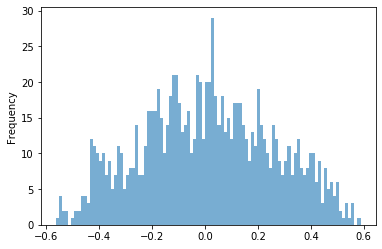

In [18]:
data_df['CosTheta'].plot.hist(bins=100, alpha=0.6)


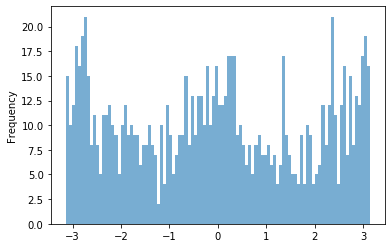

In [19]:
data_df['Phi'].plot.hist(bins=100, alpha=0.6)


## Probe matrix
The probe matrix \\(\rho(l)\\) is defined as follows:
\\[\rho(l) = \frac{1+a}{3}\cdot \delta_{ij} - a{\cdot}l_i\cdot l_j - ib\cdot \epsilon_{ijk}\cdot l_k,\\]
where \\(a = 0.5\\) and \\(b = c_A{\cdot}c_V = \sin^2\theta_W \simeq 0.22\\).

In [3]:
def ProbeMatrix( CosTheta, Phi, returnValue ):
    rho      = np.array([[-999.j, -999.j, -999.j], [-999.j, -999.j, -999.j], [-999.j, -999.j, -999.j]])
    SinTheta = math.sqrt(1 - CosTheta*CosTheta)
    CosPhi   = math.cos(Phi)
    SinPhi   = math.sin(Phi)
    l = [ SinTheta*CosPhi, SinTheta*SinPhi, CosTheta ]
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                epsilon = LeviCivita(i,j,k)
                delta = -999.
                if i == j:
                    delta = 0.5
                else:
                    delta = 0.
                rho[i][j] = delta - 0.5*l[i]*l[j]- (1j)*0.22*epsilon*l[k]
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]

    

In [21]:
%timeit Probe = ProbeMatrix( -0.419608,  -2.426581, 0 )


3.98 ms ± 60.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
for j in range(0,3):
    print(1j)

1j
1j
1j


### Saving the dataframe to file for later

In [23]:
# data_df.to_pickle("DataframeCohJpsiTransverse.txt")
# data_df.to_pickle("DataframeCohJpsiTransverseRecon.txt")
# data_df.to_pickle("DataframeCohJpsiLongitudinalRecon.txt")
data_df.to_pickle("DataframeGammaRecon.txt")

In [4]:
# data_df = pd.read_pickle("DataframeCohJpsiTransverse.txt")
data_df = pd.read_pickle("DataframeCohJpsiTransverseRecon.txt")
# data_df = pd.read_pickle("DataframeCohJpsiLongitudinalRecon.txt")
# data_df = pd.read_pickle("DataframeGammaRecon.txt")
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578


### 3D maps

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


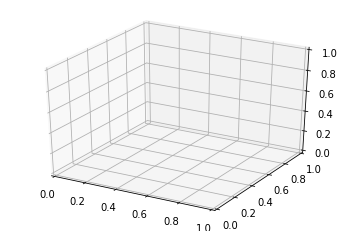

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.set_aspect("equal")


In [11]:
# draw sphere
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="r")


In [12]:
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)


In [13]:
def ApplyCos(x):
    return np.cos(x)

def ApplySin(x):
    return np.sin(x)

def ApplyCosToSin(x):
    return np.sqrt(1-x*x)

def ApplyInverseCos(x):
    return np.arccos(x)

def ApplyInverseSin(x):
    return np.arcsin(x)

def ApplyInverseTan(y,x):
    return math.atan2(y,x)


In [14]:
CosThetaColumn = data_df.loc[:,'CosTheta']
PhiColumn      = data_df.loc[:,'Phi']
# data_df['Theta'] = data_df.apply(lambda x: ApplyInverseCos(x['CosTheta']  ), axis=1)
# data_df


In [15]:
CosPhiColumn   = np.vectorize(ApplyCos)(PhiColumn)
SinPhiColumn   = np.vectorize(ApplySin)(PhiColumn)
SinThetaColumn = np.vectorize(ApplyCosToSin)(CosThetaColumn)

In [16]:
xArray = SinThetaColumn*CosPhiColumn
yArray = SinThetaColumn*SinPhiColumn
zArray = CosThetaColumn

In [17]:
# ax.plot_wireframe(xArray, yArray, zArray, color="r")

In [18]:
# from mayavi import mlab


In [19]:
# from mayavi import mlab
# # import numpy as np

# # Create a sphere
# r = 1.0
# pi = np.pi
# cos = np.cos
# sin = np.sin
# phi, theta = np.mgrid[0:pi:101j, 0:2 * pi:101j]

# x1 = r*sin(phi)*cos(theta)
# y1 = r*sin(phi)*sin(theta)
# z1 = r*cos(phi)

# mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
# mlab.clf()

# # data = np.genfromtxt('leb.txt')
# # xx, yy, zz = np.hsplit(data, 3)


# mlab.mesh(x1 , y1 , z1, color=(0.0,0.5,0.5))
# mlab.points3d(xArray, yArray, zArray, scale_factor=0.05)


# mlab.show()


In [20]:
a

NameError: name 'a' is not defined

/opt/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1773: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


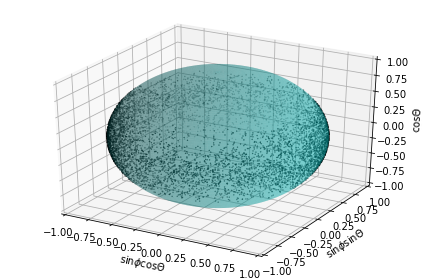

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Import data
# data = np.genfromtxt('leb.txt')
# theta, phi, r = np.hsplit(data, 3) 
# theta = theta * pi / 180.0
# phi = phi * pi / 180.0
# xx = sin(phi)*cos(theta)
# yy = sin(phi)*sin(theta)
# zz = cos(phi)


#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

# ax.scatter(xx,yy,zz,color="k",s=20)
ax.scatter(xArray,yArray,zArray,color="k",s=0.1)
# ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
# ax.plot_surface( xArray,yArray,zArray, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
# ax.set_aspect("equal")
# plt.xlabel("CosTheta")
# plt.xlabel("$\sin\phi\cos\Theta$")
# plt.ylabel("$\sin\phi\sin\Theta$")
# plt.zlabel("$\cos\Theta$")
ax.set_xlabel("$\sin\phi\cos\Theta$")
ax.set_ylabel("$\sin\phi\sin\Theta$")
ax.set_zlabel("$\cos\Theta$")
plt.tight_layout()
plt.show()

In [22]:
# from matplotlib import cm


# def random_point( r=1 ):
#     ct = 2*np.random.rand() - 1
#     st = np.sqrt( 1 - ct**2 )
#     phi = 2* np.pi *  np.random.rand()
#     x = r * st * np.cos( phi)
#     y = r * st * np.sin( phi)
#     z = r * ct
#     return np.array( [x, y, z ] )

# def near( p, pntList, d0 ):
#     cnt=0
#     for pj in pntList:
#         dist=np.linalg.norm( p - pj )
#         if dist < d0:
#             cnt += 1 - dist/d0
#     return cnt


# """
# https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
# """

# # pointList = np.array([ random_point( 10.05 ) for i in range( 65 ) ] )
# pointList = np.array([ random_point( 10.05 ) for i in range( 100 ) ] )


# fig = plt.figure()
# ax = fig.add_subplot( 1, 1, 1, projection='3d')

# u = np.linspace( 0, 2 * np.pi, 120)
# v = np.linspace( 0, np.pi, 60 )

# # create the sphere surface
# XX = 10 * np.outer( np.cos( u ), np.sin( v ) )
# YY = 10 * np.outer( np.sin( u ), np.sin( v ) )
# ZZ = 10 * np.outer( np.ones( np.size( u ) ), np.cos( v ) )
# XX2 = 10 * np.outer( np.cos( data_df['Phi'] ), np.sin( data_df['Theta'] ) )
# YY2 = 10 * np.outer( np.sin( data_df['Phi'] ), np.sin( data_df['Theta'] ) )
# ZZ2 = 10 * np.outer( np.ones( np.size( data_df['Phi'] ) ), np.cos( data_df['Theta'] ) )

# WW = XX.copy()
# for i in range( len( XX ) ):
#     for j in range( len( XX[0] ) ):
#         x = XX2[ i, j ]
#         y = YY22[ i, j ]
#         z = ZZ[ i, j ]
#         WW[ i, j ] = near(np.array( [x, y, z ] ), pointList, 3)
# #         WW[ i, j ] = near(np.array( [xArray, yArray, zArray ] ), pointList, 3)
# WW = WW / np.amax( WW )
# myheatmap = WW

# # ~ ax.scatter( *zip( *pointList ), color='#dd00dd' )
# ax.plot_surface( XX2, YY2,  ZZ2, cstride=1, rstride=1, facecolors=cm.jet( myheatmap ) )
# plt.show() 

In [23]:
data_df['ThetaBins'] = data_df['Theta'].div(np.pi*0.01)
data_df['ThetaBins']

entry
0       57.694612
1       53.642434
2       40.149178
3       49.660250
4       44.042943
          ...    
7393    49.507350
7394    48.685660
7395    32.695701
7396    41.412810
7397    54.607563
Name: ThetaBins, Length: 7398, dtype: float64

In [24]:
def truncate(x):
    import math as m
    return m.trunc(x)

In [25]:
a = 10.1
truncate(a)

10

In [26]:
data_df['ThetaBins2'] = data_df.apply(lambda x:  truncate(x['ThetaBins']), axis=1 )
# data_df['Theta'] = data_df.apply(lambda x: ApplyInverseCos(x['CosTheta']), axis=1)
data_df['ThetaBins2']

entry
0       57
1       53
2       40
3       49
4       44
        ..
7393    49
7394    48
7395    32
7396    41
7397    54
Name: ThetaBins2, Length: 7398, dtype: int64

In [27]:
data_df['PhiBins']  = data_df['Phi'].div(np.pi*0.02)
data_df['PhiBins2'] = data_df.apply(lambda x:  truncate(x['PhiBins']), axis=1 )
data_df['PhiBins2']

entry
0        2
1      -17
2       33
3      -20
4       30
        ..
7393    18
7394    48
7395   -25
7396    21
7397   -32
Name: PhiBins2, Length: 7398, dtype: int64

In [28]:
# data_df['PhiBins2'  ].to_pickle("CohJpsiTransversePhi.txt")
# data_df['ThetaBins2'].to_pickle("CohJpsiTransverseTheta.txt")

In [29]:
# with open("PhiBins.txt", 'a') as f:
#     f.write(
#         data_df['PhiBins2'].to_string(header = False, index = False)
#     )


In [30]:
# with open("ThetaBins.txt", 'a') as g:
#     g.write(
#         data_df['ThetaBins2'].to_string(header = False, index = False)
#     )


## Eigenvalue analysis

In [5]:
from numpy import linalg as al
from numpy.linalg import eig as eig

In [6]:
# create all probe matrices and store them
data_df['ProbeMatrix'] = data_df.apply(lambda x: ProbeMatrix( x['CosTheta'], x['Phi'], 0 ), axis=1)

In [7]:
# data_df.to_pickle("DataframeCohJpsiTransverse.txt")
# data_df.to_pickle("DataframeCohJpsiTransverseRecon.txt")
# data_df.to_pickle("DataframeCohJpsiLongitudinalRecon.txt")
data_df.to_pickle("DataframeGammaRecon.txt")
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578


In [36]:
%timeit ProbeEigValues, ProbeEigVectors = eig(Probe)
ProbeEigValues

NameError: name 'Probe' is not defined

In [37]:
# example to how to use more columns together
# df[["sq_a","cube_a"]] = df.apply(lambda x: [x.a**2, x.a**3], axis=1, result_type="expand")


In [38]:
data_df[['EigValues','EigVecs']] = data_df.apply(lambda x: eig(x['ProbeMatrix']  ), axis=1, result_type="expand")


In [39]:
# data_df.to_pickle("DataframeCohJpsiTransverse.txt")
data_df.to_pickle("DataframeCohJpsiTransverseRecon.txt")
# data_df.to_pickle("DataframeCohJpsiLongitudinalRecon.txt")
# data_df.to_pickle("DataframeGammaRecon.txt")
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,CosTheta,Phi,Theta,ThetaBins,ThetaBins2,PhiBins,PhiBins2,ProbeMatrix,EigValues,EigVecs
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,-0.239386,0.173410,1.812530,57.694612,57,2.759905,2,"[[(0.04268519560074707+0j), (-0.08010751091363...",[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793..."
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,-0.114181,-1.093191,1.685227,53.642434,53,-17.398675,-17,"[[(0.395736451431898+0j), (0.201447836475467+0...",[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ..."
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,0.304556,2.082901,1.261324,40.149178,40,33.150401,33,"[[(0.39107935466033406+0j), (0.193765759805425...",[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (..."
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,0.010673,-1.314234,1.560123,49.660250,49,-20.916689,-20,"[[(0.46780746728725864+0j), (0.122711342157111...",[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),..."
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,0.186056,1.890898,1.383650,44.042943,44,30.094579,30,"[[(0.4522072886143399+0j), (0.1441700267851396...",[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,0.015476,1.182376,1.555319,49.507350,49,18.818094,18,"[[(0.42830005656451087+0j), (-0.17521559014193...",[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),..."
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,0.041279,3.071524,1.529505,48.685660,48,48.884818,48,"[[(0.0032986352046518452+0j), (0.0348604083609...",[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603..."
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,0.517247,-1.576003,1.027166,32.695701,32,-25.082859,-25,"[[(0.4999900736768665+0j), (-0.001906619716458...",[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ..."


##### Cleaning those eigenvalues
If the imaginary part of the eigenvalues
is really small, then the eigenvector is considered real.

In [40]:
def CheckIfQuasiRealEigValues(x):
    import cmath
    z = [ 0., 0., 0. ]
    if x[0].imag < 1.e-12:
        z[0] = x[0].real
    else:
        z[0] = x[0]
    if x[1].imag < 1.e-12:
        z[1] = x[1].real
    else:
        z[1] = x[1]        
    if x[2].imag < 1.e-12:
        z[2] = x[2].real
    else:
        z[2] = x[2]
    return z    

In [41]:
# data_df = pd.read_pickle("DataframeCohJpsiTransverse.txt")
data_df = pd.read_pickle("DataframeCohJpsiTransverseRecon.txt")
# data_df = pd.read_pickle("DataframeCohJpsiLongitudinalRecon.txt")
# data_df = pd.read_pickle("DataframeGammaRecon.txt")
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,CosTheta,Phi,Theta,ThetaBins,ThetaBins2,PhiBins,PhiBins2,ProbeMatrix,EigValues,EigVecs
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,-0.239386,0.173410,1.812530,57.694612,57,2.759905,2,"[[(0.04268519560074707+0j), (-0.08010751091363...",[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793..."
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,-0.114181,-1.093191,1.685227,53.642434,53,-17.398675,-17,"[[(0.395736451431898+0j), (0.201447836475467+0...",[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ..."
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,0.304556,2.082901,1.261324,40.149178,40,33.150401,33,"[[(0.39107935466033406+0j), (0.193765759805425...",[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (..."
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,0.010673,-1.314234,1.560123,49.660250,49,-20.916689,-20,"[[(0.46780746728725864+0j), (0.122711342157111...",[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),..."
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,0.186056,1.890898,1.383650,44.042943,44,30.094579,30,"[[(0.4522072886143399+0j), (0.1441700267851396...",[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,0.015476,1.182376,1.555319,49.507350,49,18.818094,18,"[[(0.42830005656451087+0j), (-0.17521559014193...",[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),..."
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,0.041279,3.071524,1.529505,48.685660,48,48.884818,48,"[[(0.0032986352046518452+0j), (0.0348604083609...",[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603..."
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,0.517247,-1.576003,1.027166,32.695701,32,-25.082859,-25,"[[(0.4999900736768665+0j), (-0.001906619716458...",[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ..."


In [42]:
data_df['EigValuesReal'] = data_df.apply(lambda x: CheckIfQuasiRealEigValues( x['EigValues'] ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,Phi,Theta,ThetaBins,ThetaBins2,PhiBins,PhiBins2,ProbeMatrix,EigValues,EigVecs,EigValuesReal
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,0.173410,1.812530,57.694612,57,2.759905,2,"[[(0.04268519560074707+0j), (-0.08010751091363...",[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0...."
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,-1.093191,1.685227,53.642434,53,-17.398675,-17,"[[(0.395736451431898+0j), (0.201447836475467+0...",[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4..."
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,2.082901,1.261324,40.149178,40,33.150401,33,"[[(0.39107935466033406+0j), (0.193765759805425...",[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4..."
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,-1.314234,1.560123,49.660250,49,-20.916689,-20,"[[(0.46780746728725864+0j), (0.122711342157111...",[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ..."
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,1.890898,1.383650,44.042943,44,30.094579,30,"[[(0.4522072886143399+0j), (0.1441700267851396...",[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,1.182376,1.555319,49.507350,49,18.818094,18,"[[(0.42830005656451087+0j), (-0.17521559014193...",[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0..."
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,3.071524,1.529505,48.685660,48,48.884818,48,"[[(0.0032986352046518452+0j), (0.0348604083609...",[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ..."
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,-1.576003,1.027166,32.695701,32,-25.082859,-25,"[[(0.4999900736768665+0j), (-0.001906619716458...",[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4..."


In [43]:
def UnpackEigValues(x, i):
    if i == 0:
        return x[0]
    if i == 1:
        return x[1]
    if i == 2:
        return x[2]

In [44]:
data_df['EigValuesReal_0'] = data_df.apply(lambda x: UnpackEigValues( x['EigValuesReal'], 0 ), axis=1)
data_df['EigValuesReal_1'] = data_df.apply(lambda x: UnpackEigValues( x['EigValuesReal'], 1 ), axis=1)
data_df['EigValuesReal_2'] = data_df.apply(lambda x: UnpackEigValues( x['EigValuesReal'], 2 ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,ThetaBins2,PhiBins,PhiBins2,ProbeMatrix,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,57,2.759905,2,"[[(0.04268519560074707+0j), (-0.08010751091363...",[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,53,-17.398675,-17,"[[(0.395736451431898+0j), (0.201447836475467+0...",[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,40,33.150401,33,"[[(0.39107935466033406+0j), (0.193765759805425...",[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,49,-20.916689,-20,"[[(0.46780746728725864+0j), (0.122711342157111...",[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,44,30.094579,30,"[[(0.4522072886143399+0j), (0.1441700267851396...",[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,49,18.818094,18,"[[(0.42830005656451087+0j), (-0.17521559014193...",[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,48,48.884818,48,"[[(0.0032986352046518452+0j), (0.0348604083609...",[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,32,-25.082859,-25,"[[(0.4999900736768665+0j), (-0.001906619716458...",[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729


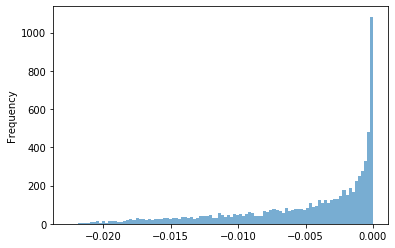

In [45]:
data_df['EigValuesReal_0'].plot.hist(bins=100, alpha=0.6)


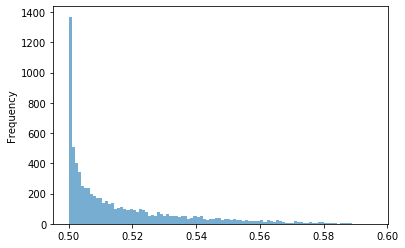

In [46]:
data_df['EigValuesReal_1'].plot.hist(bins=100, alpha=0.6)


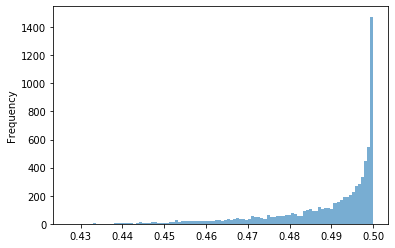

In [47]:
data_df['EigValuesReal_2'].plot.hist(bins=100, alpha=0.6)


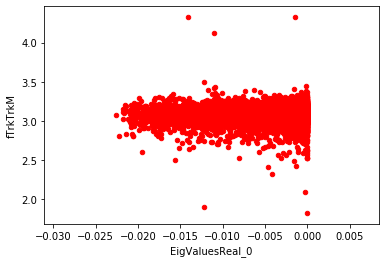

In [48]:
# ax1 = data_df.plot.scatter(x='EigValuesReal_0',y='fMCTrkTrkM',c='Red')
ax1 = data_df.plot.scatter(x='EigValuesReal_0',y='fTrkTrkM',c='Red')


In [49]:
# data_df.plot.scatter(x='EigValuesReal_1',y='fMCTrkTrkM',c='Blue', ax = ax1)
data_df.plot.scatter(x='EigValuesReal_1',y='fTrkTrkM',c='Blue', ax = ax1)


<function matplotlib.pyplot.show(*args, **kw)>

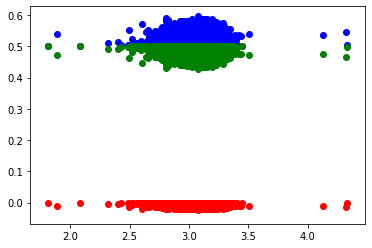

In [50]:
import pylab
# plt.scatter(data_df['EigValuesReal_0'],data_df['fMCTrkTrkM'],c='Red')
# plt.scatter(data_df['EigValuesReal_1'],data_df['fMCTrkTrkM'],c='Blue')
# plt.scatter(data_df['EigValuesReal_2'],data_df['fMCTrkTrkM'],c='Green')
# plt.scatter(data_df['EigValuesReal_0'],data_df['fTrkTrkM'],c='Red')
# plt.scatter(data_df['EigValuesReal_1'],data_df['fTrkTrkM'],c='Blue')
# plt.scatter(data_df['EigValuesReal_2'],data_df['fTrkTrkM'],c='Green')
plt.scatter(data_df['fTrkTrkM'],data_df['EigValuesReal_0'],c='Red')
plt.scatter(data_df['fTrkTrkM'],data_df['EigValuesReal_1'],c='Blue')
plt.scatter(data_df['fTrkTrkM'],data_df['EigValuesReal_2'],c='Green')
plt.show

In [35]:
with open("EigValues0_Gamma.txt", 'a') as f:
# with open("EigValues0_Longitudinal.txt", 'a') as f:
# with open("EigValues0.txt", 'a') as f:
    f.write(
        data_df['EigValuesReal_0'].to_string(header = False, index = False)
#         data_df_Eig0.to_string(header = False, index = False)
    )
with open("EigValues1_Gamma.txt", 'a') as f:
# with open("EigValues1_Longitudinal.txt", 'a') as f:
# with open("EigValues1.txt", 'a') as f:
    f.write(
        data_df['EigValuesReal_1'].to_string(header = False, index = False)
#         data_df_Eig0.to_string(header = False, index = False)
    )
with open("EigValues2_Gamma.txt", 'a') as f:
# with open("EigValues2_Longitudinal.txt", 'a') as f:
# with open("EigValues2.txt", 'a') as f:
    f.write(
        data_df['EigValuesReal_2'].to_string(header = False, index = False)
#         data_df_Eig0.to_string(header = False, index = False)
    )
with open("Mass_Gamma.txt", 'a') as f:
# with open("Mass_Longitudinal.txt", 'a') as f:
# with open("Mass.txt", 'a') as f:
    f.write(
        data_df['fTrkTrkM'].to_string(header = False, index = False)
#         data_df_Eig0.to_string(header = False, index = False)
    )


KeyError: 'EigValuesReal_0'

## Applying functional form of the AxE

In [8]:
def AxE_CosTheta( CosThetaToBeWeighted ):
    val = 0; 
    par = [ 1.84270e-04, 1.35000e-02, 2.52572e+00, 4.49481e-01, 7.71374e-01, 4.10537e-01,-1.91331e-03,-4.33903e+00, 4.44258e-01,-7.64919e-01, 4.32631e-04, 1.48228e-02, 2.75000e+00 ]
    if   CosThetaToBeWeighted < -0.550:
        val = par[0] + par[1] * ( CosThetaToBeWeighted + 0.650 ) + par[2] * ( CosThetaToBeWeighted + 0.650 ) * ( CosThetaToBeWeighted + 0.650 )
    elif CosThetaToBeWeighted < -0.125:
        val = par[3] + par[4] * CosThetaToBeWeighted
    elif CosThetaToBeWeighted <  0.125:
        val = par[5] + par[6] * CosThetaToBeWeighted + par[7] * CosThetaToBeWeighted * CosThetaToBeWeighted
    elif CosThetaToBeWeighted <  0.550:
        val = par[8] + par[9] * CosThetaToBeWeighted
    else:    
        val = par[10] + par[11] * ( CosThetaToBeWeighted - 0.650 ) + par[12] * ( CosThetaToBeWeighted - 0.650 ) * ( CosThetaToBeWeighted - 0.650 )
#     if   CosThetaToBeWeighted[0] < -0.550:
#         val = par[0] + par[1] * ( CosThetaToBeWeighted[0] + 0.650 ) + par[2] * ( CosThetaToBeWeighted[0] + 0.650 ) * ( CosThetaToBeWeighted[0] + 0.650 )
#     elif CosThetaToBeWeighted[0] < -0.125:
#         val = par[3] + par[4] * CosThetaToBeWeighted[0]
#     elif CosThetaToBeWeighted[0] <  0.125:
#         val = par[5] + par[6] * CosThetaToBeWeighted[0] + par[7] * CosThetaToBeWeighted[0] * CosThetaToBeWeighted[0]
#     elif CosThetaToBeWeighted[0] <  0.550:
#         val = par[8] + par[9] * CosThetaToBeWeighted[0]
#     else:    
#         val = par[10] + par[11] * ( CosThetaToBeWeighted[0] - 0.650 ) + par[12] * ( CosThetaToBeWeighted[0] - 0.650 ) * ( CosThetaToBeWeighted[0] - 0.650 )
    return val


In [9]:
def AxE( CosTheta, Phi ):
    par    = [ 2.05530e+03, 5.00000e-04, 1.00000e-04 ]
    fitval = 0
    fitval = par[0]*AxE_CosTheta(CosTheta)*(par[1]+par[2]*math.cos(2*Phi));
    return fitval


In [10]:
# test
TestingCosTheta = 0.186056
TestingPhi      = 1.890898
AxE_corr = AxE(TestingCosTheta, TestingPhi)
AxE_corr

0.2605201365454531

In [11]:
data_df['AxE'] = data_df.apply(lambda x: AxE( x['CosTheta'], x['Phi'] ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578


In [12]:
def CorrectedCosTheta(CosTheta, AxE):
    CorrectedCosThetaValue = CosTheta / AxE
    return CorrectedCosThetaValue
#     return CosTheta

def CorrectedPhi(Phi, AxE):
    CorrectedPhiValue = Phi / AxE
    return CorrectedPhiValue

def AxE_inverse(AxE):
    Inverse = 1. / AxE
    return Inverse

In [13]:
data_df['CorrCosTheta'] = data_df.apply(lambda x: CorrectedCosTheta( x['CosTheta'], x['AxE'] ), axis=1)
data_df['CorrPhi']      = data_df.apply(lambda x: CorrectedPhi(      x['Phi'],      x['AxE'] ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578


In [14]:
data_df['AxE_inverse'] = data_df.apply(lambda x: AxE_inverse( x['AxE'] ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigValues,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,[(-0.005178917312177293-3.0013609715609757e-18...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,[(-0.001242507530096709+2.790774291902238e-19j...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,[(-0.00803003608922341-3.472564919815358e-18j)...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,[(-1.1026036278719784e-05+8.716195372599634e-2...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,[(-0.00321497916988468+2.2751484697610634e-18j...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,[(-2.317894902571433e-05-1.6944131705738161e-1...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,[(-0.00016461163003790564+5.479430556085108e-2...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,[(-0.018530211900979587-5.5336135736751326e-18...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578


In [15]:
data_df.to_pickle("DataframeCohJpsiTransverseRecon.txt")


In [16]:
with open("CosThetaReconJpsi.txt", 'a') as f:
    f.write(
        data_df['CosTheta'].to_string(header = False, index = False)
    )
with open("PhiReconJpsi.txt", 'a') as f:
    f.write(
        data_df['Phi'].to_string(header = False, index = False)
    )
with open("AxEinverse.txt", 'a') as f:
    f.write(
        data_df['AxE_inverse'].to_string(header = False, index = False)
    )
with open("AxE.txt", 'a') as f:
    f.write(
        data_df['AxE'].to_string(header = False, index = False)
    )
# with open("CosThetaReconJpsiCorr.txt", 'a') as f:
#     f.write(
#         data_df['CosTheta'].to_string(header = False, index = False)
#     )
# with open("PhiReconJpsiCorr.txt", 'a') as f:
#     f.write(
#         data_df['Phi'].to_string(header = False, index = False)
#     )
    
    
# with open('star.txt', 'w') as f:
#     for a, b, name in zip(data_df['CosTheta'], data_df['Phi'], array3):
#         f.write('{0:15}{1:15}{2:15}\n'.format(name, a, b))    


In [17]:
def AxE_CosTheta_closure( CosThetaToBeWeighted ):
    val = 0; 
    par = [ -1.90267e-03, 1.64993e-02, 2.75000e+00, 4.63378e-01, 7.77394e-01,
             4.37958e-01,-5.29215e-02,-4.89512e+00, 4.53152e-01,-7.93050e-01,
            -5.20841e-04, 1.35817e-02, 2.74615e+00 ]
    if   CosThetaToBeWeighted < -0.550:
        val = par[0] + par[1] * ( CosThetaToBeWeighted + 0.650 ) + par[2] * ( CosThetaToBeWeighted + 0.650 ) * ( CosThetaToBeWeighted + 0.650 )
    elif CosThetaToBeWeighted < -0.125:
        val = par[3] + par[4] * CosThetaToBeWeighted
    elif CosThetaToBeWeighted <  0.125:
        val = par[5] + par[6] * CosThetaToBeWeighted + par[7] * CosThetaToBeWeighted * CosThetaToBeWeighted
    elif CosThetaToBeWeighted <  0.550:
        val = par[8] + par[9] * CosThetaToBeWeighted
    else:    
        val = par[10] + par[11] * ( CosThetaToBeWeighted - 0.650 ) + par[12] * ( CosThetaToBeWeighted - 0.650 ) * ( CosThetaToBeWeighted - 0.650 )
    return val



def AxE_closure( CosTheta, Phi ):
    par    = [ 1.38523e+03, 6.97923e-04, 1.53930e-04 ]
    fitval = 0
    fitval = par[0]*AxE_CosTheta(CosTheta)*(par[1]+par[2]*math.cos(2*Phi));
    return fitval


def AxE_inverse_closure(AxE):
    Inverse = 1. / AxE
    return Inverse

In [18]:
data_df['AxE_closure'] = data_df.apply(lambda x: AxE_closure( x['CosTheta'], x['Phi'] ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigVecs,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse,AxE_closure
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,"[[(0.952243601396123+0j), (-0.1215700679944793...","[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759,0.309134
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,"[[(-0.4547991762046905-0.05597421489257575j), ...","[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125,0.298812
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,"[[(-0.454510716704887+0.14281819668070517j), (...","[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626,0.180860
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,"[[(-0.2537335382870649+0.004854761847025392j),...","[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055,0.320234
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,"[[(-0.3061053349642764+0.08391921001989888j), ...","[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474,0.240278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,"[[(0.37865397481878627+0.007356304503887647j),...","[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817,0.333603
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,"[[(0.9965333017854131+0j), (0.0544039719479603...","[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159,0.474778
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,"[[(0.004219731390456381+0.1868765713810145j), ...","[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578,0.036628


In [19]:
data_df['AxE_inverse_closure'] = data_df.apply(lambda x: AxE_inverse_closure( x['AxE_closure'] ), axis=1)
data_df

,fTrkTrkPt,fTrkTrkY,fTrkTrkM,fTrkPx1,fTrkPy1,fTrkPz1,fTrkE1,fTrkPx2,fTrkPy2,fTrkPz2,...,EigValuesReal,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,AxE,CorrCosTheta,CorrPhi,AxE_inverse,AxE_closure,AxE_inverse_closure
entry,,,,,,,,,,,,,,,,,,,,,
0,0.088716,-3.711062,3.209101,-1.277109,-0.808316,-39.780717,39.809559,1.359299,0.841714,-25.826728,...,"[-0.005178917312177293, 0.5153964250740193, 0....",-0.005179,0.515396,0.489782,0.323336,-0.740363,0.536315,3.092759,0.309134,3.234839
1,0.066346,-2.857881,3.186917,-0.219694,-1.549150,-15.295529,15.375712,0.164928,1.586601,-12.384350,...,"[-0.001242507530096709, 0.503552487093866, 0.4...",-0.001243,0.503552,0.497690,0.321945,-0.354660,-3.395587,3.106125,0.298812,3.346584
2,0.144831,-3.309976,3.024312,0.612624,1.340739,-14.863292,14.936583,-0.692796,-1.220121,-26.538489,...,"[-0.00803003608922341, 0.5246534286602988, 0.4...",-0.008030,0.524653,0.483377,0.194567,1.565306,10.705333,5.139626,0.180860,5.529128
3,0.011350,-2.723685,3.102365,0.408992,1.490984,-11.629090,11.731889,-0.399146,-1.496631,-11.903641,...,"[-1.1026036278719784e-05, 0.5000311745162798, ...",-0.000011,0.500031,0.499980,0.347940,0.030676,-3.777182,2.874055,0.320234,3.122717
4,0.016375,-3.275739,3.151254,-1.536930,-0.178279,-16.976062,17.046753,1.533508,0.162265,-24.660436,...,"[-0.00321497916988468, 0.5093671521113141, 0.4...",-0.003215,0.509367,0.493848,0.260520,0.714171,7.258164,3.838474,0.240278,4.161845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0.068205,-3.878629,3.164547,1.496912,-0.460035,-37.347817,37.380783,-1.501691,0.528073,-39.152622,...,"[-2.317894902571433e-05, 0.5000655422014724, 0...",-0.000023,0.500066,0.499958,0.360774,0.042898,3.277329,2.771817,0.333603,2.997571
7394,0.248025,-3.532575,2.962825,0.211292,1.591286,-26.470786,26.519625,-0.194545,-1.343827,-24.345049,...,"[-0.00016461163003790564, 0.5004660535555276, ...",-0.000165,0.500466,0.499699,0.496239,0.083185,6.189609,2.015159,0.474778,2.106246
7395,0.243285,-3.105716,3.100040,-0.502214,1.231217,-8.380181,8.485677,0.717526,-1.117955,-26.261092,...,"[-0.018530211900979587, 0.567801410679664, 0.4...",-0.018530,0.567801,0.450729,0.039961,12.943878,-39.438798,25.024578,0.036628,27.301468


In [20]:
with open("AxEinverse.txt", 'a') as f:
    f.write(
        data_df['AxE_inverse_closure'].to_string(header = False, index = False)
    )


In [ ]:
# df_Rapidity_gen = df_gener.query('fMCTrkTrkM > 2.8 & fMCTrkTrkM < 3.3 & fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
df_Rapidity_gen = df_gener.query('fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
generatedevents_Ycut = len(df_Rapidity_gen.index)
generatedevents_Ycut

In [ ]:
InvMass_recon = df_recon['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
# minv_bkgMine = df_backgroundMine['fInvariantMassDimuon'].plot.hist(bins=100, alpha=0.6)


In [ ]:
InvMass_gen = df_gener['fMCTrkTrkM'].plot.hist(bins=100, alpha=0.6)


### Pandas 

Pandas is a library that provides data structures and analysis tools for Pyhton. The two primary data structures of pandas are **Series** (1-dimensional) and **DataFrame** (2-dimensional) and we will work with them.

- **Series** are 1-dimensional ndarray with axis labels.
- **DataFrame** are 2-dimensional tabular data structure with labeled axes (rows and columns).

For more details: https://pandas.pydata.org/pandas-docs/stable/





One of the most interesting tool of DataFrame is the *query()* method (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html). With this method we can query the DataFrame getting elements which **satisfy a boolean expression**.

A "trick" to plot more than one distribution is to create a new dataframe with the data to plot in different columns

In [ ]:
#dataframe with invariant-mass of background and signal
# df_new = pd.concat([df_background['InvMass'], df_signal['InvMass']], axis=1)
# df_new.head()

In [ ]:
# minv_compared = df_new.plot.hist(bins=100, alpha=0.6)

## Data preparation
We need to tell at the model what is signal and what is background.

So we add a 'y' column and label signal and background with **y=1** for signal and **y=0** for background. Then we stack togheter signal and background. This will be the reference for the ML model. 

In [ ]:
plot_VZERO = df_recon['fV0TotalNCells'].plot.hist(bins=100, alpha=0.6)


In [ ]:
plot_fL0inputs = df_recon['fL0inputs'].plot.hist(bins=100, alpha=0.6)


In [ ]:
def return0MSL(x):
    return ((x & (1<<5))>>5)

In [ ]:
def return0MUL(x):
    return ((x & (1<<13))>>13)

In [ ]:
df_recon['f0MSL'] = df_recon.fL0inputs.apply(return0MSL)
plot_0MSL = df_recon['f0MSL'].plot.hist(bins=100, alpha=0.6)


In [ ]:
df_recon['f0MUL'] = df_recon.fL0inputs.apply(return0MUL)
plot_0MUL = df_recon['f0MUL'].plot.hist(bins=100, alpha=0.6)


In [ ]:
len(df_recon.index)

In [ ]:
df_InvMassCutPlusRapidity_for0MUL = df_recon.query('fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
plot_0MUL_rightrapidity = df_InvMassCutPlusRapidity_for0MUL['f0MUL'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusRapidity_for0MUL.index)

In [ ]:
df_InvMassCutPlusRapidity = df_recon.query('fTrkTrkM > 2.8 & fTrkTrkM < 3.3 & fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
df_InvMassCutPlusTriggerConditionPlusRapidity = df_InvMassCutPlusRapidity.query('f0MUL > 0.5')
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
reconstructedevents = len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)
reconstructedevents
# len(df_InvMassCutPlusRapidity.index)

In [ ]:
InvMass_recAfterCuts = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)

In [ ]:
AxE = reconstructedevents/generatedevents_Ycut
AxE

### Template for Pt distr

In [ ]:
bins = np.arange(0,5, 0.10)

In [ ]:
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].hist(bins=bins)

In [ ]:
PtDistr = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].to_numpy()

In [ ]:
counts, edges, plot = plt.hist(PtDistr, bins=bins)

In [ ]:
counts

Now we can fit the distribution and extract the signal

In [ ]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=[2.96, 3.05])
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(2.96, 3.05, 0.00001)
    r_red = np.arange(2.98, 3.005, 0.0001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 2.99, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r_red, gaus_function(r_red, N=popt[2], mu=popt[3], sigma=popt[4]), label='gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+gauss', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, 2.98, 3.005, args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, 2.98, 3.005, args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.title(f'significance: {significance:.1f}')
    plt.legend()
    plt.xlabel('$M_{^{3}He+\pi}$ $(\mathrm{GeV/}c^2)$')
    plt.ylabel('counts / 2.25 $\mathrm{MeV/}c^2$')
    plt.show()

In [ ]:
fit_invmass(inv_sel_simple)

### Optimized model
We can optimize the hyper-parameters to have a **more complex model**

## Final Excercise

Using the query function of pandas perform the "standard" selections

In [ ]:
df_lin_sel = df_data.query('V0CosPA > 0.995')
inv_mass_lin_sel = df_lin_sel['InvMass']

In [ ]:
fit_invmass(inv_mass_lin_sel)

In [ ]:
import ROOT